# Basic Data Exploration

The dataset used in this notebook is one month of tweets (July 2018) that were downloaded from archive.org's twitter stream, extracted, and saved to .csv. To obtain only finance related tweets, a regex filter was used to obtain tweets that had a cashtag. Based on a quick review of a sample of tweets, it looks like the majority are finance related. The ultimate goal is to perform sentiment analysis of the tweets and predict future stock price based on the sentiment analysis.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from collections import Counter
import re
import html
import textacy.preprocessing as tprep
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
import textacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
# load the data set that was saved at the end of the previous notebook
tweets = pd.read_csv('july_finance_tweets.csv')
tweets.shape

(39385, 15)

In [3]:
tweets.head(2)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,user_name,screen_name,user_verified,user_lang,regex_matches
0,239,239,Wed Jul 18 06:30:20 +0000 2018,1019469400934703104,RT @tradingroomapp: #Bitcoin what next?\n\n$BT...,en,False,False,False,"[{'text': 'Bitcoin', 'indices': [20, 28]}]",Coin [shreds every coin] Shredder,ShredderSupport,False,en,['$BTC']
1,1316,1316,Wed Jul 18 06:32:16 +0000 2018,1019469887457103872,Fidus Investment Corp $FDUS Receives Consensus...,en,False,True,False,[],Ticker Report,TickerReport,False,en,['$FDUS']


In [5]:
tweets.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'tweet_date', 'tweet_id', 'tweet_text',
       'lang', 'retweet', 'tweet_url', 'tweet_reply', 'hashes', 'user_name',
       'screen_name', 'user_verified', 'user_lang', 'regex_matches'],
      dtype='object')

In [6]:
tweets.dtypes

Unnamed: 0        int64
Unnamed: 0.1      int64
tweet_date       object
tweet_id          int64
tweet_text       object
lang             object
retweet            bool
tweet_url          bool
tweet_reply        bool
hashes           object
user_name        object
screen_name      object
user_verified      bool
user_lang        object
regex_matches    object
dtype: object

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39385 entries, 0 to 39384
Data columns (total 15 columns):
Unnamed: 0       39385 non-null int64
Unnamed: 0.1     39385 non-null int64
tweet_date       39385 non-null object
tweet_id         39385 non-null int64
tweet_text       39385 non-null object
lang             39385 non-null object
retweet          39385 non-null bool
tweet_url        39385 non-null bool
tweet_reply      39385 non-null bool
hashes           39385 non-null object
user_name        39372 non-null object
screen_name      39385 non-null object
user_verified    39385 non-null bool
user_lang        39385 non-null object
regex_matches    39385 non-null object
dtypes: bool(4), int64(3), object(8)
memory usage: 3.5+ MB


In [3]:
# add new column that contains the length of the tweet
tweets['length'] = tweets['tweet_text'].str.len()

In [9]:
tweets['length'].describe()

count    39385.000000
mean       108.795938
std         32.839124
min          5.000000
25%         86.000000
50%        116.000000
75%        140.000000
max        171.000000
Name: length, dtype: float64

Twitter increased the character limit from 140 to 280 in 2017 (before the tweets in this dataset were created). It doesn't look like most users take advantage of the increased limit.

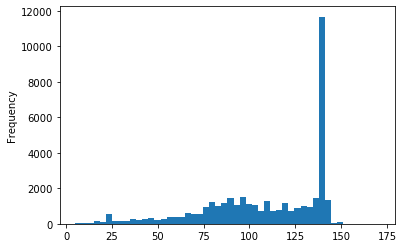

In [10]:
tweets['length'].plot(kind='hist', bins=50)

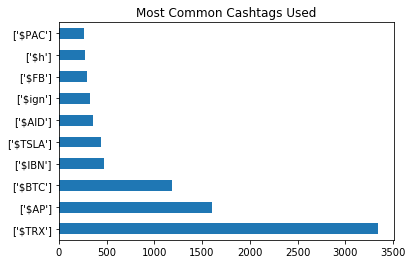

In [11]:
tweets['regex_matches'].value_counts().head(10).plot.barh(title='Most Common Cashtags Used')

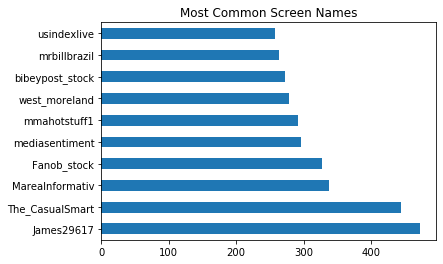

In [12]:
tweets['screen_name'].value_counts().head(10).plot.barh(title='Most Common Screen Names')

In [13]:
# basic function to tokenize tweets with regex
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [14]:
# import stopwords from nltk library
stopwords = set(nltk.corpus.stopwords.words('english'))

In [15]:
# return lowercase words if they are not included in the stop words list
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [16]:
# pull all the preprocessing functions together
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [17]:
# quick processing pipeline to prepare the tweets into tokens
pipeline = [str.lower, tokenize, remove_stop]

tweets['tokens'] = tweets['tweet_text'].apply(prepare, pipeline=pipeline)
tweets.head(1)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,user_name,screen_name,user_verified,user_lang,regex_matches,length,tokens
0,239,239,Wed Jul 18 06:30:20 +0000 2018,1019469400934703104,RT @tradingroomapp: #Bitcoin what next?\n\n$BT...,en,False,False,False,"[{'text': 'Bitcoin', 'indices': [20, 28]}]",Coin [shreds every coin] Shredder,ShredderSupport,False,en,['$BTC'],140,"[rt, tradingroomapp, bitcoin, next, btc, smash..."


In [18]:
# get number of tokens per tweets
tweets['num_tokens'] = tweets['tokens'].map(len)
tweets.sample(1)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,user_name,screen_name,user_verified,user_lang,regex_matches,length,tokens,num_tokens
38350,282326,282326,Mon Jul 02 14:32:58 +0000 2018,1013792653731745792,Bioanalytical Systems acquires Seventh Wave La...,en,False,True,False,[],Breaking News,MarketCurrents,False,en,['$BASI'],112,"[bioanalytical, systems, acquires, seventh, wa...",13


In [19]:
# top ten most comment tokens
token_counter = Counter()
tweets['tokens'].map(token_counter.update)
token_counter.most_common(10)

[('co', 30432),
 ('https', 30377),
 ('rt', 16866),
 ('trx', 6861),
 ('tron', 3327),
 ('justinsuntron', 3267),
 ('btc', 3241),
 ('amp', 2725),
 ('inc', 2347),
 ('new', 2334)]

In [7]:
# reformat the regex_matches column so that each item in the column is its own list
new_format = [None] * len(tweets['regex_matches'])

for i in range(len(tweets['regex_matches'])):
    new_format[i] = (tweets['regex_matches'].iloc[i].strip("[]''"))

tweets['regex_matches'] = new_format

In [21]:
tweets.sample(1)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,user_name,screen_name,user_verified,user_lang,regex_matches,length,tokens,num_tokens
15711,561243,561243,Mon Jul 30 20:03:31 +0000 2018,1024022699608301568,$IRCArt.. Just saying @smoss 🤷🏽‍♀️ https://t.c...,en,False,False,False,[],Vanna D.,iSongBird,False,en,$IRCArt,58,"[ircart, saying, smoss, https, co, n8itdhgwww]",6


In [22]:
# top ten regex_matches / cashtags
cashtag_counter = Counter()
for i in tweets['regex_matches']:
    cashtag_counter.update({i:1})
cashtag_counter.most_common(10)

[('$TRX', 3341),
 ('$AP', 1608),
 ('$BTC', 1180),
 ('$IBN', 476),
 ('$TSLA', 439),
 ('$AID', 353),
 ('$ign', 321),
 ('$FB', 298),
 ('$h', 274),
 ('$PAC', 260)]

In [24]:
# top ten screen names
sn_counter = Counter()
for i in tweets['screen_name']:
    sn_counter.update({i:1})
sn_counter.most_common(10)

[('James29617', 473),
 ('The_CasualSmart', 445),
 ('MareaInformativ', 338),
 ('Fanob_stock', 327),
 ('mediasentiment', 296),
 ('mmahotstuff1', 292),
 ('west_moreland', 278),
 ('bibeypost_stock', 272),
 ('mrbillbrazil', 263),
 ('CFinancialNews', 257)]

In [25]:
# word counter function that returns pandas DataFrame
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else process(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [26]:
cashtag_freq = pd.DataFrame.from_dict(cashtag_counter, orient='index', columns=['freq'])
cashtag_freq.head(1)

,freq
$BTC,1180


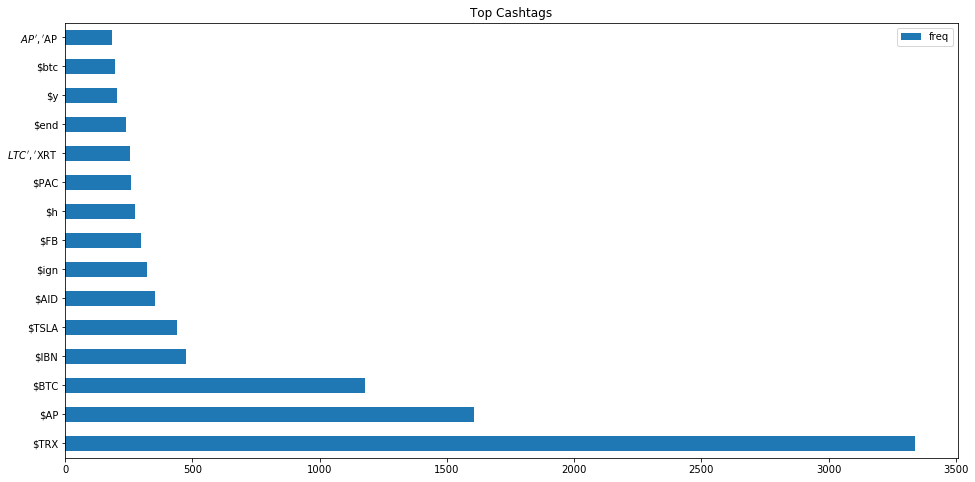

In [27]:
cashtag_freq.sort_values(by='freq', ascending=False).head(15).plot.barh(title='Top Cashtags', figsize=(16,8))

In [28]:
# function to compute idf
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    
    # count tokens
    counter = Counter()
    df[column].map(update)
    
    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1
    idf_df.index.name = 'token'
    return idf_df

In [30]:
# compute idf
idf_df = compute_idf(tweets)
idf_df.shape

C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(20342, 2)

In [31]:
# compute tf-idf
freq_df = count_words(tweets)
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

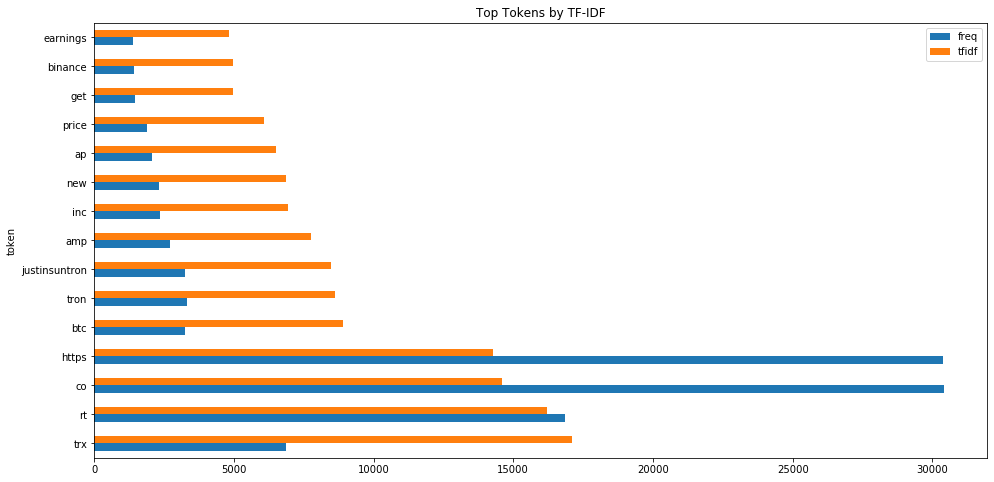

In [35]:
freq_df.sort_values(by='tfidf', ascending=False).head(15).plot.barh(title='Top Tokens by TF-IDF', figsize=(16,8))

Looking at the top results makes me feel pretty good about the quality of the dataset. Once I do some cleanup (remove words/tokens like https, co, rt, etc.), I'm left with the symbols for companies (trx, tron, inc) and finance related terms (earnings, price, justinsuntron (the creator of a crytocurrency)).

In [37]:
# function to create ngrams
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
               if len([t for t in ngram if t in stopwords])==0]

In [38]:
# get bigrams from the tweet dataset
tweets['bigrams'] = tweets['tweet_text'].apply(prepare, pipeline=[str.lower, tokenize]) \
                                        .apply(ngrams, n=2, stopwords=stopwords)

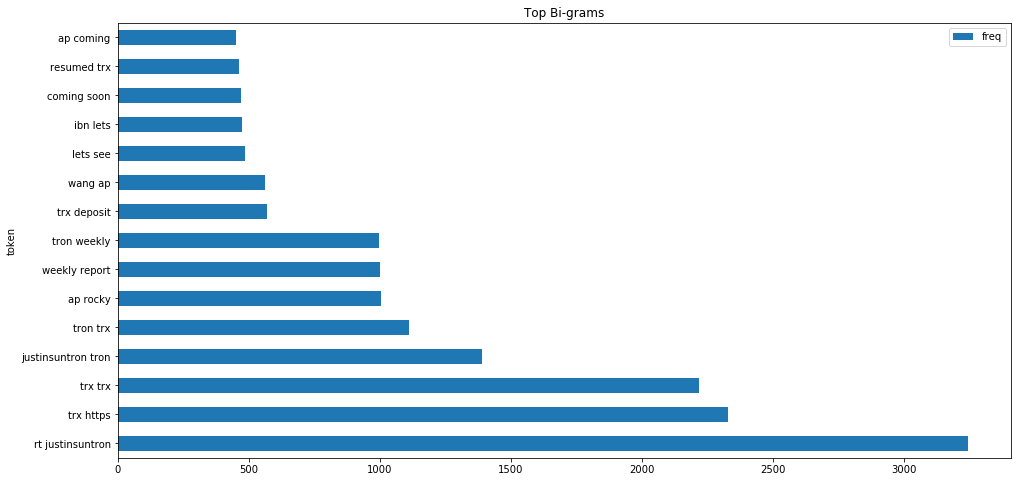

In [40]:
count_words(tweets, 'bigrams').head(15).plot.barh(title='Top Bi-grams', figsize=(16,8))

# Data Cleaning

In [66]:
# use regex to test for special characters/noise
RE_SUSPICOUS = re.compile(r'[&<>{}\[\]\\]')

# fuction to compute what percentage of the tweet is noise, based on the regex filter
def impurity(text, min_len=10):
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICOUS.findall(text))/len(text)

In [67]:
# top 20 tweets with the highest percentage of noise
tweets['tweet_text'].apply(impurity, min_len=10).sort_values(ascending=False).head(20)

13420    0.100000
10100    0.085714
36309    0.085106
9026     0.075758
15954    0.074468
4591     0.074468
5376     0.071429
20237    0.070588
3662     0.063830
6291     0.060606
13606    0.059172
38778    0.058824
13348    0.056604
12851    0.054264
12852    0.053030
24670    0.051471
4702     0.051095
28280    0.050000
24381    0.049505
5892     0.049505
Name: tweet_text, dtype: float64

In [49]:
# text of the tweet that has one of the highest percentage of noise
tweets.iloc[10100].tweet_text

'RT @_Unleash_Fury_: #Overwatch #LIVEstream is ON @Twitch!\n\n[]\\[]O[]\\[]-$TO[]D Expert #Competitive Matches @_Unleash_Fury_\n\nhttps://t.co/Jlo…'

In [68]:
# add the "impurity score" to the main DataFrame
tweets['impurity'] = tweets['tweet_text'].apply(impurity, min_len=10)

In [69]:
# look at the five noisiest tweets
pd.set_option('max_colwidth', 300)
tweets[['tweet_text', 'impurity']].sort_values(by='impurity', ascending=False).head()

,tweet_text,impurity
13420,$AMRN strong move &gt;&gt;&gt;,0.100000
10100,RT @_Unleash_Fury_: #Overwatch #LIVEstream is ON @Twitch!\n\n[]\[]O[]\[]-$TO[]D Expert #Competitive Matches @_Unleash_Fury_\n\nhttps://t.co/Jlo…,0.085714
36309,ty dolla $ign part on anything &gt;&gt;&gt;&gt;,0.085106
9026,Purity by A$AP feat. Frank Ocean &gt;&gt;&gt;&gt;&gt; ur fave song,0.075758
15954,RT @ErnieGnc: Mood: A$AP Rocky &amp; Rihanna &gt;&gt;&gt;&gt;&gt;&gt; https://t.co/5IqsF2j9bB,0.074468


In [98]:
# function to clean up text
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # convert tags
    text = re.sub(r'<[^<>]*>', ' ', text)
    # convert web links to the string 'URL'
#     text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', 'URL', text)
    text = re.sub(r'https:\S+', 'URL', text)
    # replace text in square brackets with a space
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # replace stand along special characters, but not hashtags or cashtags
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    text = re.sub(r'[@%&]+', ' ', text)
    # replace sequences of certain standalone characters
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    text = re.sub(r'>+', ' ', text)
    text = re.sub(r'<+', ' ', text)
    text = re.sub(r'(\+)', ' ', text)
    
    # replace sequences of whitespace with one space
    text = re.sub(r'\s+', ' ', text)
    # remove leading and trailing whitespace
    return text.strip()

In [99]:
# add a new column with the clean text, update impurity based on cleaned text
tweets['clean_text'] = tweets['tweet_text'].map(clean)
tweets['impurity'] = tweets['clean_text'].apply(impurity, min_len=10)
tweets[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head()

,clean_text,impurity
14183,curl -sk URL perl -nle '$f=0; for(m/functions\/(.*?).html/gi){$f++}; $t +=$f; END{ print $t }… URL,0.051020
17903,"RT RamBlush: *Follow retweet LIKE $PAC :*""}{",0.045455
17010,"RT RamBlush: *Follow retweet LIKE $PAC :*""}{",0.045455
12852,"Roel Aaij, Rolf Andreassen et al.: Test of lepton universality using $B^{+}\right... URL",0.034091
12851,Takeo Kojima: Diagonalization of transfer matrix of supersymmetry $u_q(\hat{sl}(m... URL,0.034091


In [100]:
t = tweets[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head()

In [101]:
t

,clean_text,impurity
14183,curl -sk URL perl -nle '$f=0; for(m/functions\/(.*?).html/gi){$f++}; $t +=$f; END{ print $t }… URL,0.051020
17903,"RT RamBlush: *Follow retweet LIKE $PAC :*""}{",0.045455
17010,"RT RamBlush: *Follow retweet LIKE $PAC :*""}{",0.045455
12852,"Roel Aaij, Rolf Andreassen et al.: Test of lepton universality using $B^{+}\right... URL",0.034091
12851,Takeo Kojima: Diagonalization of transfer matrix of supersymmetry $u_q(\hat{sl}(m... URL,0.034091


In [108]:
re.sub(r'(\+)', ' ', t['clean_text'].iloc[0])

"curl -sk URL perl -nle '$f=0; for(m/functions\\/(.*?).html/gi){$f  }; $t  =$f; END{ print $t }… URL"

# Preprocessing 

In [4]:
# function to normalize text - I'm using pretty much all of textacy's pre-processing functions since Twitter data
# is pretty messy
def normalize(text):
    text = html.unescape(text)
    text = tprep.normalize_hyphenated_words(text)
    text = tprep.normalize_quotation_marks(text)
    text = tprep.normalize_unicode(text)
    text = tprep.normalize_whitespace(text)
    text = tprep.remove_accents(text)
    text = tprep.replace_emails(text)
    text = tprep.replace_urls(text)
    return text.lower()

In [5]:
# add new column with normalized text
tweets['normalized_text'] = tweets['tweet_text'].apply(normalize)
tweets['normalized_text'].sample(1)

28507    people spreading fud about $zcl are the ones w...
Name: normalized_text, dtype: object

In [23]:
pd.set_option('max_colwidth',1)
tweets['normalized_text'].head(10)

0    rt @tradingroomapp: #bitcoin what next?\n$btc smashed through minor resistance to test the broken trendline/100 dma area. we have booked pr...
1    fidus investment corp $fdus receives consensus rating of "hold" from brokerages _url_                                                         
2    the coca-cola $ko to release quarterly earnings on wednesday _url_                                                                            
3    home bancshares inc forecasted to post q3 2018 earnings of $0.46 per share $homb _url_ #markets                                               
4    intec pharma ltd $ntec given consensus rating of "buy" by analysts _url_                                                                      
5    $gne #genesis energy morningstar | genesis energy is a diversified energy company with a mix of renewable and therm... _url_                  
6    fidus investment corp $fdus given consensus rating of "hold" by analysts _url_                             

In [24]:
# tokenization with nltk
tokenizer = nltk.tokenize.TweetTokenizer()
tweets['nltk_tokens'] 

['rt',
 '@tradingroomapp',
 ':',
 '#bitcoin',
 'what',
 'next',
 '?',
 '$',
 'btc',
 'smashed',
 'through',
 'minor',
 'resistance',
 'to',
 'test',
 'the',
 'broken',
 'trendline',
 '/',
 '100',
 'dma',
 'area',
 '.',
 'we',
 'have',
 'booked',
 'pr',
 '...']

In [27]:
nlp = spacy.load('en_core_web_sm')
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x238c546f1c8>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x238c546fd68>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x238c51a0dd8>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x238c51a0f28>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x238c546e348>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x238c5489288>)]

In [50]:
doc = nlp(tweets['normalized_text'][100])

In [42]:
for token in doc:
    print(token, end='|')

rt|@thewolfofalts|:|this|looks|awesome|!|$|ion|$|xdm|$|btc|$|eth|_|url|_|

In [36]:
def display_nlp(doc, include_punct=False):
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i, 'text':t.text, 'lemma_':t.lemma_, 'is_stop':t.is_stop, 'is_alpha':t.is_alpha, 
                   'pos_':t.pos_, 'dep_':t.dep_, 'sentiment':t.sentiment, 'ent_type_':t.ent_type_, 
                   'ent_iob_':t.ent_iob_}
            rows.append(row)
            
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [51]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,sentiment,ent_type_,ent_iob_
0,rt,rt,False,True,INTJ,ROOT,0.0,,O
1,@kevynsmit,@kevynsmit,False,False,NOUN,ROOT,0.0,,O
3,morning,morning,False,True,NOUN,npadvmod,0.0,TIME,B
5,\n,\n,False,False,SPACE,ROOT,0.0,,O
6,i,I,True,True,PRON,nsubj,0.0,,O
7,'ll,'ll,True,False,AUX,aux,0.0,,O
8,take,take,True,True,VERB,ROOT,0.0,,O
9,some,some,True,True,DET,det,0.0,,O
10,requests,request,False,True,NOUN,dobj,0.0,,O
11,in,in,True,True,ADP,prep,0.0,,O


In [52]:
doc.sentiment

0.0

In [59]:
# testing a custom tokenizer function

def custom_tokenizer(nlp):
    prefixes = [pattern for pattern in nlp.Defaults.prefixes if pattern not in ['-', '_', '#', '$']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ['_']]
    infixes = [pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, 'xx-xx')]
    
    return Tokenizer(vocab = nlp.vocab,
                     rules = nlp.Defaults.tokenizer_exceptions,
                     prefix_search = compile_prefix_regex(prefixes).search,
                     suffix_search = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match = nlp.Defaults.token_match)

nlp = spacy.load('en_core_web_sm')

In [60]:
nlp.tokenizer = custom_tokenizer(nlp)

In [61]:
doc = nlp(tweets['normalized_text'][8])
for token in doc:
    print(token, end='|')

rt|@thewolfofalts|:|this|looks|awesome|!|$|ion|$|xdm|$|btc|$|eth|_url_|

In [62]:
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
non_stop

[rt, @thewolfofalts, looks, awesome, $, ion, $, xdm, $, btc, $, eth, _url_]

In [68]:
print(*[t.lemma_ for t in doc], sep='|')

rt|@thewolfofalt|:|this|look|awesome|!|$|ion|$|xdm|$|btc|$|eth|_url_


In [69]:
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
nouns

[rt, @thewolfofalts, ion, xdm, btc, eth, _url_]

In [72]:
tokens = textacy.extract.words(doc,
                              filter_stops = True,
                              filter_punct = True,
                              filter_nums = True,
                              include_pos = ['ADJ', 'NOUN'],
                              exclude_pos = None,
                              min_freq = 1)

print(*[t for t in tokens], sep='|')

@thewolfofalts|awesome|ion|xdm|btc|eth


In [73]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

In [75]:
lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

@thewolfofalt|awesome|ion|xdm|btc|eth


In [76]:
for ent in doc.ents:
    print(f'({ent.text}, {ent.label_})', end=' ')

(eth, MONEY) 

In [87]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

In [98]:
# fucntion to extract everything I need
def extract_nlp(doc):
    return {
        'lemmas': extract_lemmas(doc, exclude_pos=['PART', 'PUNCT', 'DET', 'PRON', 'SYM', 'SPACE'], 
                                 filter_stops=False),
        'adjs_verbs': extract_lemmas(doc, include_pos=['ADJ', 'VERB']),
        'nouns': extract_lemmas(doc, include_pos=['NOUN', 'PROPN']),
        'noun_phrases': extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
        'entities': extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

I've realized that some of the data cleaning I've done isn't wise to do when trying to perform sentiment analysis, so I won't be using all the preprocessing steps I've performed.

# Sentiment Analysis

In [6]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\ckell\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [7]:
print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words in opinion lexicon', opinion_lexicon.positive()[:5])
print('Examples of negative words in opinion lexicon', opinion_lexicon.negative()[:5])

Total number of words in opinion lexicon 6789
Examples of positive words in opinion lexicon ['a+', 'abound', 'abounds', 'abundance', 'abundant']
Examples of negative words in opinion lexicon ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']


In [8]:
# create dictionary for scoring text
pos_score = 1
neg_score = -1
word_dict = {}

In [9]:
# add positive words to dictionary
for word in opinion_lexicon.positive():
    word_dict[word] = pos_score

In [10]:
# add negative words to dictionary
for word in opinion_lexicon.negative():
    word_dict[word] = neg_score

In [11]:
# fucntion to give a sentiment score to each tweet based on the number of positive or negative words in the bing liu 
# lexicon divided by the total number of words in the tweet. Positive words count as +1, negative words as -1.
def bing_liu_score(text):
    sentiment_score = 0
    # convert text to lower case and tokenize
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

In [15]:
# add bing liu score to dataset using non-normalized data and normailzed data
tweets['bing_liu_score'] = tweets['tweet_text'].apply(bing_liu_score)
tweets['bing_liu_score_normalized'] = tweets['normalized_text'].apply(bing_liu_score)
tweets[['tweet_text', 'bing_liu_score', 'bing_liu_score_normalized']].sample(3)

,tweet_text,bing_liu_score,bing_liu_score_normalized
29607,$LIT Lithium https://t.co/1G5RGuKBAp,0.000000,0.000000
2576,Pzena Investment Management $PZN Rating Lowere...,0.058824,0.066667
16854,🔔Thank you for ringing the Opening Bell with u...,0.000000,0.000000


In [22]:
# tweet with highest bing liu score
tweets.iloc[np.argmax(tweets['bing_liu_score'])]

C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


Unnamed: 0                                230771
Unnamed: 0.1                              230771
tweet_date        Mon Jul 30 13:35:57 +0000 2018
tweet_id                     1023925165246369792
tweet_text                 Super bullish on $btc
lang                                          en
retweet                                    False
tweet_url                                  False
tweet_reply                                False
hashes                                        []
user_name                              BitWalker
screen_name                           BitWalker_
user_verified                              False
user_lang                                     en
regex_matches                           ['$btc']
bing_liu_score                               0.4
Name: 15010, dtype: object

In [12]:
# using the VADER lexicon instead, which is supposed to be good for social media text
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ckell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
sid = SentimentIntensityAnalyzer()

In [25]:
# sentiment scores of the first tweet
sid.polarity_scores(tweets['tweet_text'].iloc[0])

{'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'compound': -0.4767}

In [14]:
# add vader scores to dataset, using non-normalized data and normalized data
tweets['vader_scores'] = tweets['tweet_text'].apply(lambda review: sid.polarity_scores(review))
tweets['vader_scores_normalized'] = tweets['normalized_text'].apply(lambda review: sid.polarity_scores(review))
tweets.sample(2)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,user_name,screen_name,user_verified,user_lang,regex_matches,normalized_text,vader_scores,vader_scores_normalized
36468,975336,975336,Tue Jul 24 02:45:02 +0000 2018,1021587029526757376,RT @cryptomocho: $btc and #alts now https://t....,en,False,False,False,"[{'text': 'alts', 'indices': [26, 31]}]",LuckDragon69,LuckDragon69,False,en,['$btc'],rt @cryptomocho: $btc and #alts now _url_,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1674,5556,5556,Wed Jul 11 18:13:29 +0000 2018,1017109639345983488,"don't miss out on registering on Binance, befo...",en,False,True,False,[],jenna rossi,jennarossi87,False,en,['$BTC'],"don't miss out on registering on binance, befo...","{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'comp...","{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'comp..."


In [16]:
# pull out the compound score from the vader scores for both sets of scores
tweets['compound_vader_score'] = tweets['vader_scores'].apply(lambda score_dict: score_dict['compound'])
tweets['compound_vader_score_norm'] = tweets['vader_scores_normalized'].apply(lambda score_dict: score_dict['compound'])
tweets.sample(2)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,...,user_verified,user_lang,regex_matches,normalized_text,vader_scores,vader_scores_normalized,bing_liu_score,bing_liu_score_normalized,compound_vader_score,compound_vader_score_norm
28659,403136,403136,Sun Jul 29 17:21:32 +0000 2018,1023619547306373120,Acadian Asset Management Has Upped Its Positio...,en,False,True,False,[],...,False,en,"['$HIBB', '$TWOU']",acadian asset management has upped its positio...,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...","{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.000000,0.0000,0.3612,0.3612
2933,296251,296251,Sun Jul 15 14:40:29 +0000 2018,1018505587603263488,Brokerages Set Ollie’s Bargain Outlet Holdings...,en,False,True,False,[],...,False,en,['$OLLI'],brokerages set ollie's bargain outlet holdings...,"{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...","{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...",0.052632,0.0625,0.2023,0.2023


In [17]:
# add pos or neg label based on compound vader score for both tweets sets, spliting positive or negative at zero
tweets['vader_sentiment_label'] = tweets['compound_vader_score'].apply(lambda c: 'pos' if c >= 0 else 'neg')
tweets['vader_sentiment_label_norm'] = tweets['compound_vader_score_norm'].apply(lambda c: 'pos' if c >= 0 else 'neg')
tweets.sample(2)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,...,regex_matches,normalized_text,vader_scores,vader_scores_normalized,bing_liu_score,bing_liu_score_normalized,compound_vader_score,compound_vader_score_norm,vader_sentiment_label,vader_sentiment_label_norm
7295,1032610,1032610,Fri Jul 20 05:05:49 +0000 2018,1020172907324952582,RT @QBankChain: 🎉QBankChain Airdrop#1 Start\n⭐...,en,False,False,False,[],...,['$QBC'],rt @qbankchain: 🎉qbankchain airdrop#1 start\n⭐...,"{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...","{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...",0.00000,0.000000,0.4767,0.4767,pos,pos
3568,710290,710290,Sun Jul 15 21:48:58 +0000 2018,1018613418968928257,RT @PACcoinOfficial: Most people don't realize...,en,False,False,False,[],...,"['$PAC', '$PAC']",rt @paccoinofficial: most people don't realize...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.03125,-0.030303,0.0000,0.0000,pos,pos


In [18]:
# make sentiment labels where 0.0 is labeled as neutral, both tweet sets
tweets['three_part_vader_label'] = tweets['compound_vader_score'].apply(lambda c: 'pos' if c > 0 else ('neg' if c < 0 else 'neu'))
tweets['three_part_vader_label_norm'] = tweets['compound_vader_score_norm'].apply(lambda c: 'pos' if c > 0 else ('neg' if c < 0 else 'neu'))
tweets.sample(2)

,Unnamed: 0,Unnamed: 0.1,tweet_date,tweet_id,tweet_text,lang,retweet,tweet_url,tweet_reply,hashes,...,vader_scores,vader_scores_normalized,bing_liu_score,bing_liu_score_normalized,compound_vader_score,compound_vader_score_norm,vader_sentiment_label,vader_sentiment_label_norm,three_part_vader_label,three_part_vader_label_norm
38348,281962,281962,Mon Jul 02 14:32:30 +0000 2018,1013792536278646784,RT @MooncoinUK: #mooncompetition Your chance t...,en,False,False,False,"[{'text': 'mooncompetition', 'indices': [16, 3...",...,"{'neg': 0.039, 'neu': 0.565, 'pos': 0.396, 'co...","{'neg': 0.04, 'neu': 0.578, 'pos': 0.383, 'com...",0.064516,0.0625,0.9191,0.9062,pos,pos,pos,pos
37137,272775,272775,Sun Jul 22 14:27:22 +0000 2018,1021039001749377029,Hawaiian Holdings Inc $HA Sentiment Increased...,en,False,True,False,[],...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...","{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",0.000000,0.0000,0.2732,0.2732,pos,pos,pos,pos


In [19]:
# save dataset
tweets.to_csv('finance_tweets_with_sentiment.csv')